<a href="https://colab.research.google.com/github/ItsShi/Mono-Depth/blob/main/Depth_DPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Dataset

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ids = ['1Q45JutY3Fu4wqf4z_Xarz6CTJnyofnSx']
zip_files = ['instrument17_valid.zip']
for id, zip_file in zip(ids, zip_files):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(zip_file)
    if zip_file[-3:] == 'zip':
        !unzip -q $zip_file

Installation

In [15]:
!pip -q install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.6 MB/s eta 0:00:00


DPT

In [ ]:
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
depth_estimation = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)

/usr/local/lib/python3.10/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
depth_estimation.parameters()

<generator object Module.parameters at 0x7ff53bcebf40>

In [ ]:
DPTFeatureExtractor

transformers.models.dpt.feature_extraction_dpt.DPTFeatureExtractor

In [ ]:
feature_extractor

DPTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "ensure_multiple_of": 1,
  "feature_extractor_type": "DPTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "DPTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "keep_aspect_ratio": false,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

In [ ]:
DPTForDepthEstimation

transformers.models.dpt.modeling_dpt.DPTForDepthEstimation

In [ ]:
from glob import glob
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tifffile
import cv2
import gdown
import os

class TestDataset(Dataset):
    def __init__(self, path_depth=None, transform=None):
        self.path_depth = path_depth
        self.transform = transform

    def __len__(self):
      return len(self.path_depth)   

    def __getitem__(self, i):
        # depth = tifffile.imread(self.path_depth[i])[:,:,2]
        img = Image.open(self.path_depth[i]).convert('RGB')
        # img = Image.open(path_[:-14] + 'Image.png').convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

#(1024, 1280, 3)
transform_test = transforms.Compose([
    transforms.Resize((256, 320)), 
    transforms.ToTensor(),    
])

data_root_dir = 'instrument17_valid/**/images/'
data_root_dir = '/content/'
img_dir = glob(data_root_dir + '*.jpg')
dataset_test = TestDataset(path_depth=img_dir, transform=transform_test)
print('test sample:', len(dataset_test))

/content/*.jpg
test sample: 1


(256, 320, 3)
torch.Size([1, 3, 384, 384])


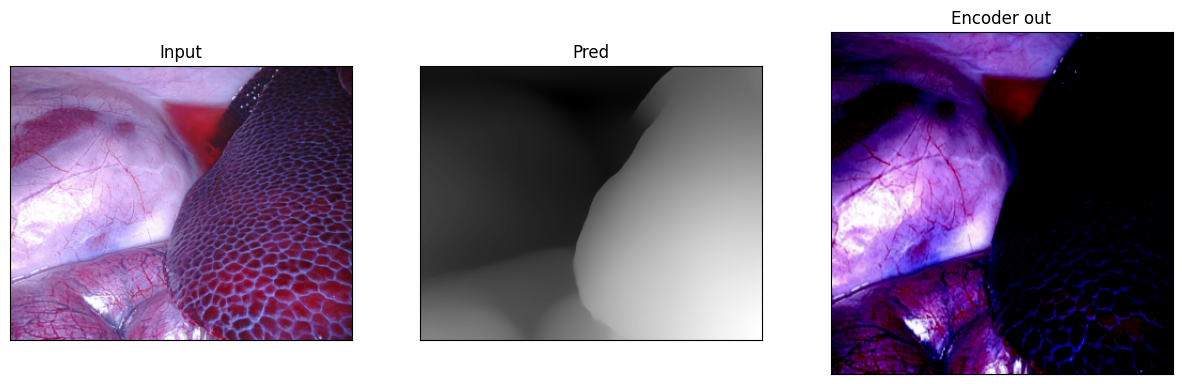

In [ ]:
image_raw = transforms.ToPILImage()(dataset_test[0])#[None]
# image = image_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
image = image_raw#.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
# image = dataset_test[0]
print(np.array(image).shape)
encoding = feature_extractor(image, return_tensors="pt").to(device)
print(encoding['pixel_values'].shape)
with torch.no_grad():
    outputs = depth_estimation(**encoding)
    # print(outputs.__dict__.keys())#['loss', 'predicted_depth', 'hidden_states', 'attentions']
    predicted_depth = outputs.predicted_depth
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        (256,320),
        mode="bicubic",
        align_corners=False,
    ).squeeze()
output = prediction.cpu().numpy() 

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(dataset_test[0].permute(1,2,0))
ax[0].set_title('Input')
ax[1].imshow(output, cmap='gray')
ax[1].set_title('Pred');
ax[2].imshow(encoding['pixel_values'][0].permute(1,2,0).cpu(), cmap='gray')
ax[2].set_title('Encoder out');

(3, 256, 320)
torch.Size([1, 3, 384, 384])


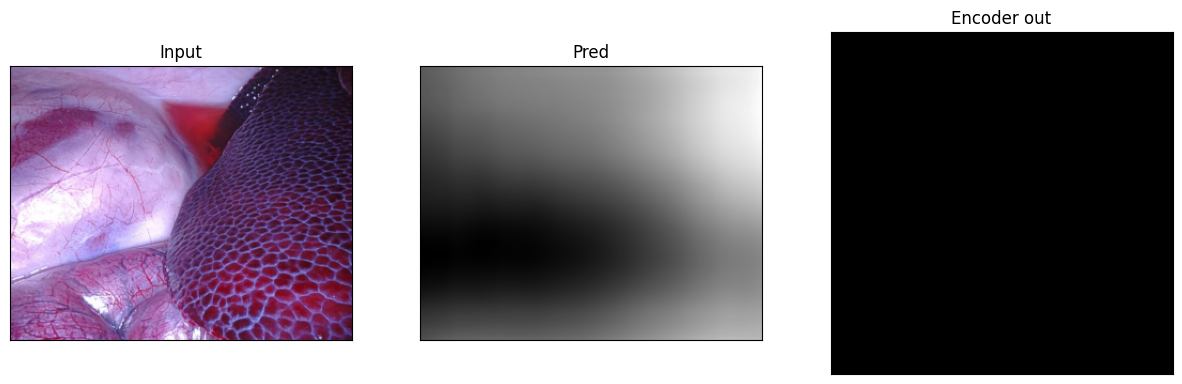

In [ ]:
# image_raw = transforms.ToPILImage()(dataset_test[0])#[None]
image = image_raw = dataset_test[0]
# image = image_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
print(np.array(image).shape)
encoding = feature_extractor(image, return_tensors="pt").to(device)
print(encoding['pixel_values'].shape)
with torch.no_grad():
    outputs = depth_estimation(**encoding)
    # print(outputs.__dict__.keys())#['loss', 'predicted_depth', 'hidden_states', 'attentions']
    predicted_depth = outputs.predicted_depth
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        (256,320),#size=image_raw.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
output = prediction.cpu().numpy() 

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(dataset_test[0].permute(1,2,0))
ax[0].set_title('Input')
ax[1].imshow(output, cmap='gray')
ax[1].set_title('Pred');
ax[2].imshow(encoding['pixel_values'][0].permute(1,2,0).cpu(), cmap='gray')
ax[2].set_title('Encoder out');

In [ ]:
encoding['pixel_values'].shape

torch.Size([1, 3, 384, 384])

In [1]:
!git clone https://github.com/ShuweiShao/SceneRF.git

Cloning into 'SceneRF'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 48 (delta 2), reused 0 (delta 0), pack-reused 42
Unpacking objects: 100% (48/48), 17.26 MiB | 12.78 MiB/s, done.


In [13]:
%cd /content/SceneRF/scenerf
!python scripts/reconstruction/generate_novel_depths.py \
    --recon_save_dir=$RECON_SAVE_DIR \
    --root=$KITTI_ROOT \
    --preprocess_root=$KITTI_PREPROCESS \
    --model_path=/path/to/model/checkpoint \
    --angle=10 --step=0.5 --max_distance=10.1
%cd /content

/content/SceneRF/scenerf
Traceback (most recent call last):
  File "/content/SceneRF/scenerf/scripts/reconstruction/generate_novel_depths.py", line 12, in <module>
    from scenerf.models.scenerf import scenerf
ModuleNotFoundError: No module named 'scenerf'
/content


In [12]:
%cd /content/SceneRF/scenerf
!python scripts/reconstruction/depth2tsdf.py \
    --recon_save_dir=$RECON_SAVE_DIR \
    --root=$KITTI_ROOT \
    --preprocess_root=$KITTI_PREPROCESS \
    --angle=10 --step=0.5 --max_distance=10.1
%cd /content

/content/SceneRF/scenerf
python3: can't open file '/content/SceneRF/scenerf/scenerf/scripts/reconstruction/depth2tsdf.py': [Errno 2] No such file or directory
/content


In [ ]:
%cd /content/SceneRF/scenerf
!python scripts/evaluation/eval_sr.py \
    --recon_save_dir=$RECON_SAVE_DIR \
    --root=$KITTI_ROOT \
    --preprocess_root=$KITTI_PREPROCESS
%cd /content

In [24]:
# https://drive.google.com/file/d/1Gx0wjnKdtHmosC860R-tXjssbMtCjr_0/view?usp=sharing
import gdown
url = 'https://drive.google.com/uc?id=1Gx0wjnKdtHmosC860R-tXjssbMtCjr_0'
gdown.download(url,'depth.pth',quiet=True) 

'depth.pth'

In [23]:
!rm depth.pth

In [ ]:
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import torch

depth_decoder = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")


In [27]:
loaded_dict = torch.load("/content/depth.pth", map_location='cpu')
print(loaded_dict.keys())
depth_decoder.load_state_dict(loaded_dict['state_dict'])

odict_keys(['dpt.embeddings.cls_token', 'dpt.embeddings.position_embeddings', 'dpt.embeddings.patch_embeddings.projection.weight', 'dpt.embeddings.patch_embeddings.projection.bias', 'dpt.encoder.layer.0.attention.attention.query.weight', 'dpt.encoder.layer.0.attention.attention.query.bias', 'dpt.encoder.layer.0.attention.attention.key.weight', 'dpt.encoder.layer.0.attention.attention.key.bias', 'dpt.encoder.layer.0.attention.attention.value.weight', 'dpt.encoder.layer.0.attention.attention.value.bias', 'dpt.encoder.layer.0.attention.output.dense.weight', 'dpt.encoder.layer.0.attention.output.dense.bias', 'dpt.encoder.layer.0.intermediate.dense.weight', 'dpt.encoder.layer.0.intermediate.dense.bias', 'dpt.encoder.layer.0.output.dense.weight', 'dpt.encoder.layer.0.output.dense.bias', 'dpt.encoder.layer.0.layernorm_before.weight', 'dpt.encoder.layer.0.layernorm_before.bias', 'dpt.encoder.layer.0.layernorm_after.weight', 'dpt.encoder.layer.0.layernorm_after.bias', 'dpt.encoder.layer.1.atten

KeyError: ignored

In [32]:
loaded_dict.popitem("height")

# , "width", "use_stereo"


('width', 320)

In [31]:
loaded_dict["height"]

256